In [1]:
!pip install eli5
!pip install xgboost

## Import of Libraries needed

In [34]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## Import Datasets

In [320]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
census = pd.read_csv('census.csv')
print(train.shape, test.shape, census.shape)

(32561, 15) (16281, 15) (48842, 15)


## Begin EDA

In [225]:
#checking for null values and column types, interesting to see no 'missing' values I'll dive a little further.
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [226]:
#Aha missing values are disguised as '?'.  Lets fix that.
census['workclass'].value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [227]:
#Found 3 Object Columns with '?' for missing values.  We will fill these with the top value of each row.
census.isin(['?']).sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

In [321]:
#Time to make the 'missing' values into NaN so we can work with them
census.replace({'?': np.NaN}, inplace=True)

In [229]:
#No more '?'
census.workclass.value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [230]:
# They are now registered as NaN.  These will be replaced with the top value_counts in each column
census.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

In [231]:
census.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [322]:
#Printing Top Values to Fill NaNs
print('Top Value:',census['native-country'].describe())
print('Top Value:',census['occupation'].describe())
print('Top Value:',census['workclass'].describe())

Top Value: count             47985
unique               41
top       United-States
freq              43832
Name: native-country, dtype: object
Top Value: count              46033
unique                14
top       Prof-specialty
freq                6172
Name: occupation, dtype: object
Top Value: count       46043
unique          8
top       Private
freq        33906
Name: workclass, dtype: object


In [323]:
#filling NaN values
census['workclass'].replace({np.NaN : 'Private'},inplace=True)
census['occupation'].replace({np.NaN : 'Prof-specialty'}, inplace=True)
census['native-country'].replace({np.NaN : 'United-States'},inplace=True)

In [234]:
#Sanity check to assure NaNs have been fixed with working values.
census.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [235]:
#checking for high cardinality in the dataset as well as seeing what to do with the features. Looks like 'fnlwgt' has a very high cardinality and isnt useful for the model
census.astype(object).nunique()

age                  74
workclass             8
fnlwgt            28523
education            16
education-num        16
marital-status        7
occupation           14
relationship          6
race                  5
sex                   2
capital-gain        123
capital-loss         99
hours-per-week       96
native-country       41
income                2
dtype: int64

#Working on the wrangle function.  Not sure how to get these three def/if/else functions wrapped into one working or multi working function inside of a wranglefunction🤔

In [324]:
#Create a New Feature that changes the income column into a 1 if they make more than 50K a year and 0 if they make 50K or less.  New Feature called 'makes-50K+'.
def over50K(census):
    if census['income'] == '>50K':
        val = 1
    else:
        val = 0
    return val
census['makes-50K+'] = census.apply(over50K, axis=1)

In [325]:
#Create a New Feature that changes the hours worked per week column into a 1 if they worked more than 40 hrs a week and 0 if they worked 40 or less.  New Feature called 'over40hrs'.
def over40(census):
    if census['hours-per-week'] >40:
        val = 1
    else:
        val = 0
    return val
census['over40hrs+'] = census.apply(over40, axis=1)

In [326]:
#Create a New Feature that changes the sex column into a 1 if they were Female and 0 if they were Male.  New Feature called 'gender-F/1-M/0'. This is new Target column.
def gender(census):
    if census['sex'] == 'Female':
            val = 1
    else:
            val = 0
    return val
census['gender-F/1-M/0'] = census.apply(gender, axis=1)

In [239]:
#checking to see new features were successful. They are all there.
census.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,makes-50K+,over40hrs+,gender-F/1-M/0
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,0,1,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,1,0,0
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,1,0,0
4,18,Private,103497,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States,<=50K,0,0,1


In [327]:
# Time to drop columns we don't need anylonger.  Feature'fnlwgt' is high card and Unnecessary while 'sex' would now become a leaky feature and income and hours per week are now redundant
census = census.drop(columns=['fnlwgt','income','hours-per-week','sex','capital-gain','capital-loss'])

In [328]:
census

,age,workclass,education,education-num,marital-status,occupation,relationship,race,native-country,makes-50K+,over40hrs+,gender-F/1-M/0
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,United-States,0,0,0
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,United-States,0,1,0
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,United-States,1,0,0
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,United-States,1,0,0
4,18,Private,Some-college,10,Never-married,Prof-specialty,Own-child,White,United-States,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,United-States,0,0,1
48838,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,United-States,1,0,0
48839,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,United-States,0,0,1
48840,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,United-States,0,0,0


# Splitting the Data

In [329]:
#Split data randomly with a 60/20/20 split

train, val, test = np.split(census.sample(frac=1), [int(.6*len(census)), int(.8*len(census))])
print('Training Set:',train.head(1))
print('Validation Set:',val.head(1))
print('Test Set',test.head(1))

Training Set:        age workclass education  education-num      marital-status  \
25295   62   Private   HS-grad              9  Married-civ-spouse   

             occupation relationship   race native-country  makes-50K+  \
25295  Transport-moving      Husband  White  United-States           1   

       over40hrs+  gender-F/1-M/0  
25295           0               0  
Validation Set:        age         workclass education  education-num marital-status  \
28118   67  Self-emp-not-inc   1st-4th              2        Widowed   

          occupation   relationship   race native-country  makes-50K+  \
28118  Other-service  Not-in-family  Black  United-States           0   

       over40hrs+  gender-F/1-M/0  
28118           0               1  
Test Set        age workclass education  education-num marital-status    occupation  \
23096   45   Private   HS-grad              9      Separated  Tech-support   

        relationship   race native-country  makes-50K+  over40hrs+  \
23096  Not

In [330]:
#Split the data into X and y for training the model and making predictions
y_train = train[target]
X_train = train.drop(target,axis=1)

In [331]:
y_val = val[target]
X_val = val.drop(target,axis=1)

In [332]:
y_test = test[target]
X_test = test.drop(target,axis=1)

# Establishing the Baseline

In [333]:
#First I will check that the target feature is between 50-70%.  Its almost to far off but still within the parameters to continue.
y_train.value_counts(normalize=True)

0    0.668214
1    0.331786
Name: gender-F/1-M/0, dtype: float64

In [334]:
y_train.value_counts()

0    19582
1     9723
Name: gender-F/1-M/0, dtype: int64

In [335]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.668213615423989


# Building the Model

In [336]:
#Starting with a pipeline. Using OrdinalEncoder for the object columns, we do not need and Imputer since they were all filled with top values and I am working with XGBClassifier.
modelxgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_jobs=-1)
)
modelxgb.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['workclass', 'education',
                                      'marital-status', 'occupation',
                                      'relationship', 'race',
                                      'native-country'],
                                mapping=[{'col': 'workclass',
                                          'data_type': dtype('O'),
                                          'mapping': Private             1
Federal-gov         2
Self-emp-not-inc    3
Local-gov           4
Self-emp-inc        5
State-gov           6
Without-pay         7
Never-worked        8
NaN                -2
dtype: int64},
                                         {'col': 'education',
                                          'data_ty...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                

In [337]:
print('Training accuracy:', modelxgb.score(X_train, y_train))
print('Validation accuracy:', modelxgb.score(X_val, y_val))

Training accuracy: 0.882852755502474
Validation accuracy: 0.8425470925470926


In [338]:
scores = cross_val_score(modelxgb, X_train, y_train, cv=20)
scores

/Users/victoriadebebe/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-vWvUDltt/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


array([0.84856753, 0.84174625, 0.84379263, 0.84174625, 0.84242838,
       0.8334471 , 0.84232082, 0.83276451, 0.84778157, 0.85324232,
       0.83208191, 0.84095563, 0.85119454, 0.85119454, 0.83686007,
       0.84163823, 0.86416382, 0.82457338, 0.8559727 , 0.85665529])

In [339]:
pipeline = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42)
)

params = {
    'randomforestclassifier__n_estimators': range(50,500,50),
    'randomforestclassifier__max_depth': range(5,101,5),
    'randomforestclassifier__max_samples': np.arange(0.2, 0.7, 0.2)
}

model = RandomizedSearchCV(
    pipeline,
    param_distributions=params,
    cv=5,
    verbose=1,
    n_iter=5
)

In [340]:
model.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   58.3s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=5,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 101, 5),
                                        'randomforestclassifier__max_samples': array([0.2, 0.4, 0.6]),
                                        'randomforestclassifier__n_estimators': range(50, 500, 50)},
                   verbose=1)

In [341]:
scores = cross_val_score(model, X_train, y_train, cv=10)
scores

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   38.2s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   36.3s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   34.4s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   15.9s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   26.9s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   49.7s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   46.1s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   26.1s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   52.7s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   24.8s finished


array([0.83862163, 0.84646878, 0.83316274, 0.8321392 , 0.84749232,
       0.8337884 , 0.84914676, 0.8443686 , 0.84334471, 0.84505119])

In [342]:
print('Training accuracy:', model.score(X_train, y_train))
print('Validation accuracy:', model.score(X_val, y_val))

Training accuracy: 0.9034294488995052
Validation accuracy: 0.8354832104832105


In [343]:

# make predictions for test data
y_pred = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.70%


In [344]:

# k-fold cross validation evaluation of xgboost model
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# load data
# split data into X and y
# CV model
model_w_kf = modelxgb
kfold = KFold(n_splits=3, random_state=7)
results = cross_val_score(modelxgb, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/Users/victoriadebebe/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-vWvUDltt/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/Users/victoriadebebe/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-vWvUDltt/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Accuracy: 83.93% (0.19%)


In [345]:
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
log_model = make_pipeline(
      OrdinalEncoder(),
      LogisticRegression(max_iter=5)
  )

log_model.fit(X_train, y_train)


/Users/victoriadebebe/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-vWvUDltt/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['workclass', 'education',
                                      'marital-status', 'occupation',
                                      'relationship', 'race',
                                      'native-country'],
                                mapping=[{'col': 'workclass',
                                          'data_type': dtype('O'),
                                          'mapping': Private             1
Federal-gov         2
Self-emp-not-inc    3
Local-gov           4
Self-emp-inc        5
State-gov           6
Without-pay         7
Never-worked        8
NaN                -2
dtype: int64},
                                         {'col': 'education',
                                          'data_ty...
Hong                          15
Cuba                          16
China                         17
Ireland                       18
Scotland                      19
Iran                          20
Jam

In [346]:
print('Training accuracy:', log_model.score(X_train, y_train))
print('Validation accuracy:', log_model.score(X_val, y_val))

Training accuracy: 0.6682477392936359
Validation accuracy: 0.672911547911548


In [347]:
from sklearn.svm import SVC
svc_model = make_pipeline(
      OrdinalEncoder(),
      SVC()
  )

svc_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['workclass', 'education',
                                      'marital-status', 'occupation',
                                      'relationship', 'race',
                                      'native-country'],
                                mapping=[{'col': 'workclass',
                                          'data_type': dtype('O'),
                                          'mapping': Private             1
Federal-gov         2
Self-emp-not-inc    3
Local-gov           4
Self-emp-inc        5
State-gov           6
Without-pay         7
Never-worked        8
NaN                -2
dtype: int64},
                                         {'col': 'education',
                                          'data_ty...
Puerto-Rico                   10
Italy                         11
Germany                       12
Philippines                   13
Vietnam                       14
Hong                          15
Cub

In [348]:
print('Training accuracy:', svc_model.score(X_train, y_train))
print('Validation accuracy:', svc_model.score(X_val, y_val))

Training accuracy: 0.7907183074560655
Validation accuracy: 0.7856265356265356


In [349]:
lin_model = make_pipeline(
      OrdinalEncoder(),
      LinearRegression()
  )

lin_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['workclass', 'education',
                                      'marital-status', 'occupation',
                                      'relationship', 'race',
                                      'native-country'],
                                mapping=[{'col': 'workclass',
                                          'data_type': dtype('O'),
                                          'mapping': Private             1
Federal-gov         2
Self-emp-not-inc    3
Local-gov           4
Self-emp-inc        5
State-gov           6
Without-pay         7
Never-worked        8
NaN                -2
dtype: int64},
                                         {'col': 'education',
                                          'data_ty...
Philippines                   13
Vietnam                       14
Hong                          15
Cuba                          16
China                         17
Ireland                       18
Sco

In [350]:
print('Training accuracy:', lin_model.score(X_train, y_train))
print('Validation accuracy:', lin_model.score(X_val, y_val))

Training accuracy: 0.36342428028378027
Validation accuracy: 0.3611681263770725


In [351]:
modelxgb.fit(X_train, y_train)
# make predictions for test data
y_pred = modelxgb.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/Users/victoriadebebe/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-vWvUDltt/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Accuracy: 84.47%


In [352]:
from sklearn.ensemble import GradientBoostingClassifier

model_skgb = make_pipeline(
    OrdinalEncoder(),
    GradientBoostingClassifier(random_state=42)
)

model_skgb.fit(X_train, y_train);

In [353]:
print('Training accuracy:', model_skgb.score(X_train, y_train))
print('Validation accuracy:', model_skgb.score(X_val, y_val))

Training accuracy: 0.846681453676847
Validation accuracy: 0.8384520884520884


In [354]:

# make predictions for test data
y_pred = model_skgb.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.17%


In [355]:
X.relationship.value_counts()

Husband           19716
Not-in-family     12583
Own-child          7581
Unmarried          5125
Wife               2331
Other-relative     1506
Name: relationship, dtype: int64

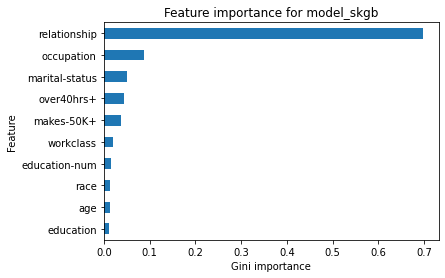

In [356]:
import matplotlib.pyplot as plt

importances = modelxgb.named_steps['xgbclassifier'].feature_importances_

feat_imp = pd.Series(importances, index=X_train.columns).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini importance')
plt.ylabel('Feature')
plt.title('Feature importance for model_skgb');

In [357]:
# Using sklearn
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(modelxgb, X_val, y_val, n_jobs=10, random_state=42)

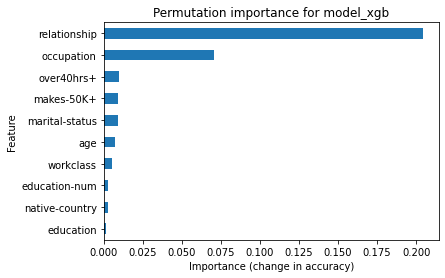

In [358]:
# Put results into DataFrame
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values('importances_mean', ascending=True, inplace=True)

# Make plot
df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb');

In [359]:
perm_imp = permutation_importance(modelxgb, X_test, y_test, n_jobs=10, random_state=42)

data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

permutation_importances = pd.DataFrame(data, index=X_test.columns)
permutation_importances.sort_values('importances_mean', ascending=True, inplace=True)
permutation_importances

,importances_mean,importances_std
education,0.000123,0.000919
native-country,0.000184,0.000683
race,0.001679,0.000437
education-num,0.003869,0.001331
workclass,0.005917,0.001203
age,0.006469,0.001116
makes-50K+,0.007984,0.000902
over40hrs+,0.010093,0.001915
marital-status,0.011936,0.002129
occupation,0.073559,0.004075


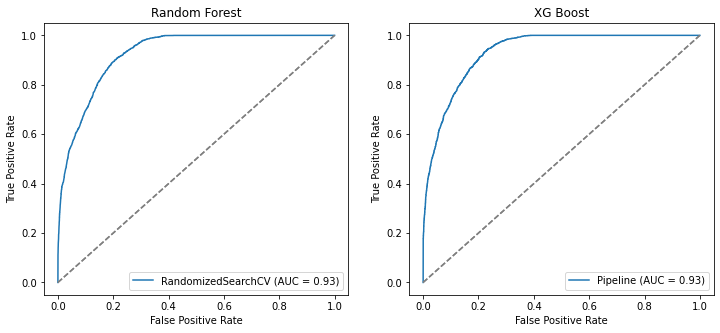

In [360]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,5))

plot_roc_curve(model, X_test, y_test, ax=ax1)
plot_roc_curve(modelxgb, X_test, y_test, ax=ax2)
ax1.plot([(0,0), (1,1)], color='grey', linestyle='--')
ax2.plot([(0,0), (1,1)], color='grey', linestyle='--')
ax1.set_title('Random Forest')
ax2.set_title('XG Boost')

plt.show()

/Users/victoriadebebe/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-vWvUDltt/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


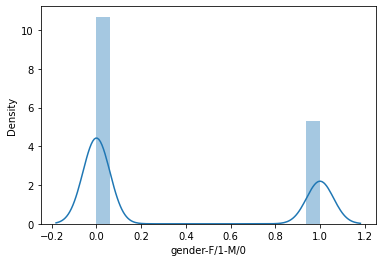

In [361]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

In [366]:
#XGBoost model made without pipeline so shap graphing would not be an issue.

import category_encoders as ce
ore = ce.OrdinalEncoder()
XTO_train = ore.fit_transform(X_train)
XTO_val = ore.transform(X_val)
modelxgb2 = XGBClassifier()

modelxgb2.fit(XTO_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [406]:
print('Training accuracy:', modelxgb2.score(XTO_train, y_train))
print('Validation accuracy:', modelxgb2.score(XTO_val, y_val))

Training accuracy: 0.882852755502474
Validation accuracy: 0.8425470925470926


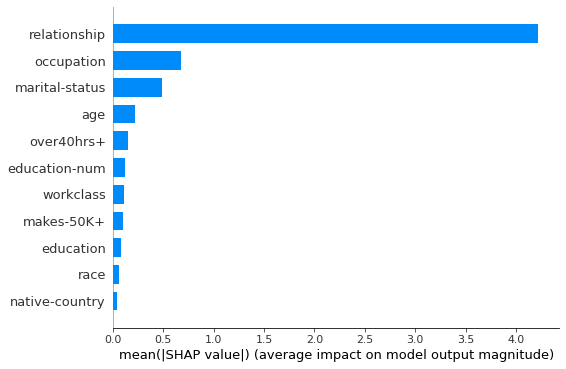

In [392]:
import shap
row2 = X_test
shap_values = shap.TreeExplainer(modelxgb2).shap_values(XTO_train)
shap.summary_plot(shap_values, XTO_train, plot_type="bar")

In [401]:
import shap
row = XTO_val.iloc[[795]]
explainer = shap.TreeExplainer(modelxgb2)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row)

In [402]:
row

,age,workclass,education,education-num,marital-status,occupation,relationship,race,native-country,makes-50K+,over40hrs+
14176,22,1,3,13,3,2,2,1,1,0,0


In [403]:
model.predict(row)

array([1])

In [404]:
row_check = y_val.iloc[[795]]
row_check

14176    1
Name: gender-F/1-M/0, dtype: int64

In [377]:
import pdpbox.pdp as pdp
from pdpbox.pdp import pdp_isolate, pdp_plot

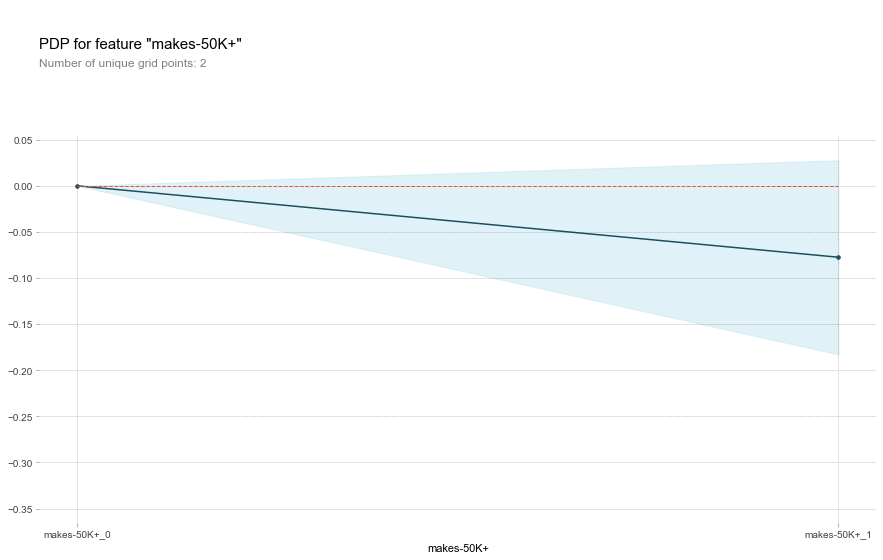

In [378]:
feature = 'makes-50K+'

isolate = pdp_isolate(
    model=model,
    dataset=XTO_test, # <-- use validation data
    model_features=XTO_test.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

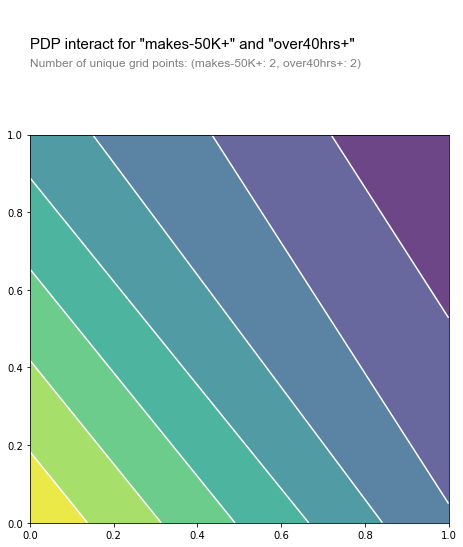

In [379]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['makes-50K+', 'over40hrs+']

interact = pdp_interact(
    model=model,
    dataset=XTO_test, # <-- use validation data
    model_features=XTO_test.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='contour', feature_names=features);

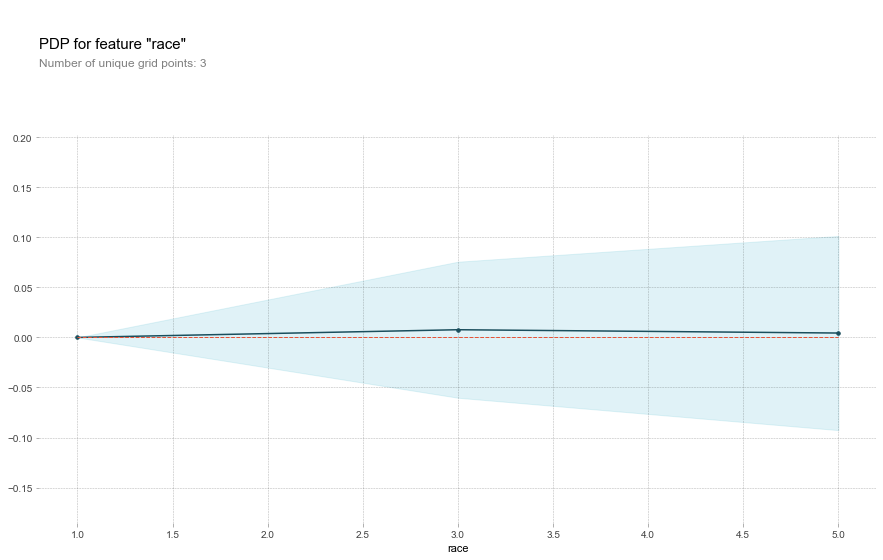

In [384]:
X_enc = ore.fit_transform(X.drop(columns=['capital-gain','capital-loss']))
model.fit(X_enc,y)
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'race'
pdp_dist = pdp.pdp_isolate(model=modelxgb2, dataset=X_enc, model_features=X_enc.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

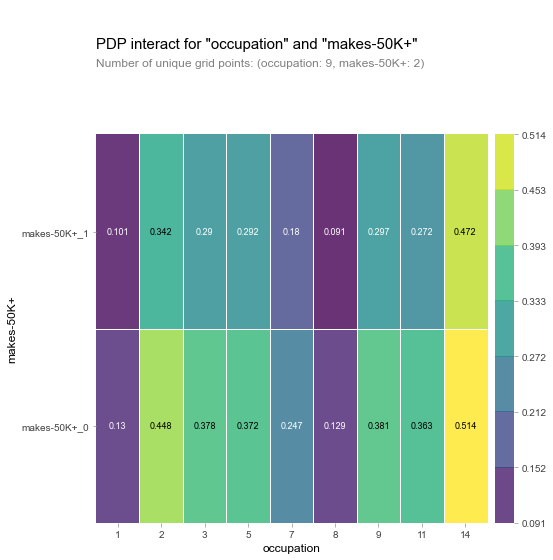

In [405]:
features = ['occupation', 'makes-50K+']

interaction = pdp_interact(
    model=modelxgb2, 
    dataset=X_enc, 
    model_features=X_enc.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);